In [31]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [33]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [34]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [35]:
df.info()
# Encontramos valores nulos en las columnas 'dropoff_longitude' y 'dropoff_latitude'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [36]:
df.isnull().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

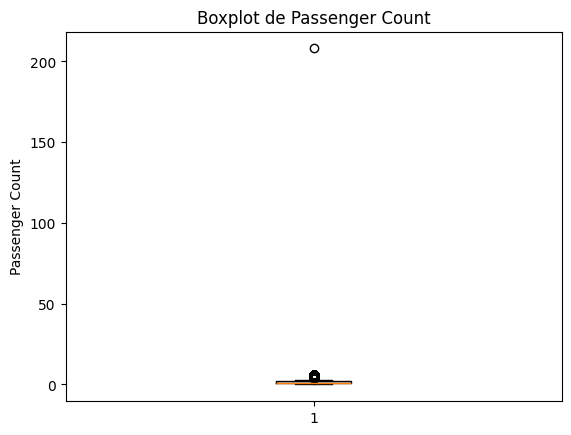

In [37]:
# Box plot de los datos de la variable fecha
plt.boxplot(df['passenger_count'])
plt.title('Boxplot de Passenger Count')
plt.ylabel('Passenger Count')
plt.show()

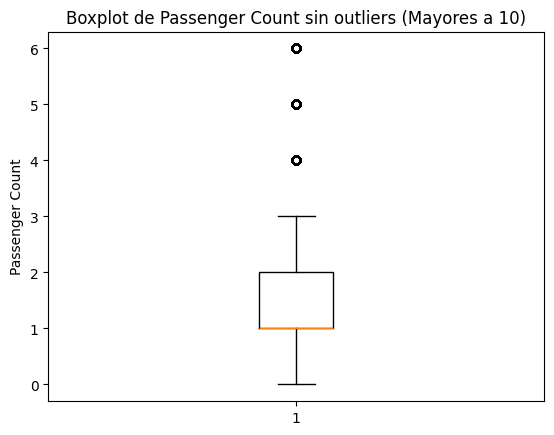

In [38]:
'''
Reemplazamos por la mediana los valores de la columna 'passenger_count' que sean mayores a 11, 
ya que es el máximo permitido en los vehiculos de la flota de Uber
'''

df_copy = df.copy()
median_value = df_copy['passenger_count'].median()
df_copy.loc[df_copy['passenger_count'] > 11, 'passenger_count'] = median_value

plt.boxplot(df_copy['passenger_count'])
plt.title('Boxplot de Passenger Count sin outliers (Mayores a 10)')
plt.ylabel('Passenger Count')
plt.show()

In [39]:
'''
Convertimos la columna 'pickup_datetime' a tipo datetime,
para luego poder dividir los datos en año, mes, día, hora, día de la semana y si es fin de semana
'''

df_copy['pickup_datetime'] = pd.to_datetime(df_copy['pickup_datetime'])

df_copy["year"] = df_copy["pickup_datetime"].dt.year
df_copy["month"] = df_copy["pickup_datetime"].dt.month
df_copy["day"] = df_copy["pickup_datetime"].dt.day
df_copy["hour"] = df_copy["pickup_datetime"].dt.hour
df_copy["weekday"] = df_copy["pickup_datetime"].dt.weekday  # 0 = Lunes, 6 = Domingo
df_copy["is_weekend"] = (df_copy["weekday"] >= 5).astype(int)  # 1 si es sábado o domingo

In [ ]:
'''
En la variable 'pickup_datetime' observamos que los valores se encuentran en rangos normales, por lo que no realizamos ninguna modificacion
'''
df_copy['pickup_datetime'].describe()

count                                 199885
mean     2012-03-22 10:00:03.928289024+00:00
min                2009-01-01 01:15:22+00:00
25%                2010-08-24 21:55:21+00:00
50%                2012-03-21 10:43:19+00:00
75%                2013-10-19 15:14:00+00:00
max                2015-06-30 23:40:39+00:00
Name: pickup_datetime, dtype: object

In [40]:
'''
Eliminamos los viajes en donde la latitud de origen o destino sea menor a -55.95 o mayor a 70.75, 
ya que estaría fuera de los límites en los que Uber opera sus viajes
'''
df_copy = df_copy[(df_copy['pickup_latitude'] > -55.95) & (df_copy['pickup_latitude'] < 70.75)]
df_copy = df_copy[(df_copy['dropoff_latitude'] > -55.95) & (df_copy['dropoff_latitude'] < 70.75)]

In [41]:
'''
Eliminamos los datos de longitud de origen o destino mayores a 180 o menores a -180,
ya que no representan coordenadas reales
'''
df_copy = df_copy[(df_copy['pickup_longitude'] > -180) & (df_copy['dropoff_longitude'] > -180)]
df_copy = df_copy[(df_copy['pickup_longitude'] < 180) & (df_copy['dropoff_longitude'] < 180)]



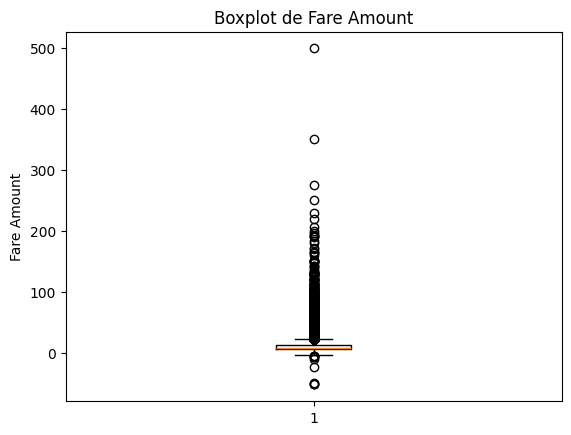

In [43]:
plt.boxplot(df_copy['fare_amount'])
plt.title('Boxplot de Fare Amount')
plt.ylabel('Fare Amount')
plt.show()


In [42]:
# Preguntar si tendriamos que eliminar viaje que sean mayores a 300 dolares, ya que casi todos los viajes cuestan menos de 300 dolares y estos fueron recogidos y dejados en el mismo lugar
print(df_copy[df_copy['fare_amount'] > 300])

             key                           date  fare_amount  \
4292    33491441  2014-10-24 20:20:00.000000181        350.0   
170081  51151143   2011-04-10 04:10:00.00000064        499.0   

                 pickup_datetime  pickup_longitude  pickup_latitude  \
4292   2014-10-24 20:20:00+00:00          0.000000         0.000000   
170081 2011-04-10 04:10:00+00:00        -73.968377        40.764602   

        dropoff_longitude  dropoff_latitude  passenger_count  year  month  \
4292             0.000000            0.0000                3  2014     10   
170081         -73.968368           40.7646                1  2011      4   

        day  hour  weekday  is_weekend  
4292     24    20        4           0  
170081   10     4        6           1  


In [50]:
print(f'Cantidad de datos previos a la limpieza: {df.shape[0]}')
print(f'Cantidad de datos posteriores a la limpieza: {df_copy.shape[0]}')

Cantidad de datos previos a la limpieza: 200000
Cantidad de datos posteriores a la limpieza: 199885


In [ ]:
# Matriz de correlación de las variables numéricas

ValueError: could not convert string to float: '2015-05-07 19:52:06.0000003'

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

In [47]:
X_train.describe()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.600000e+05,160000.000000,160000.000000,159999.000000,159999.000000,160000.000000
mean,2.771233e+07,-72.525896,39.936265,-72.525260,39.919258,1.684988
std,1.603218e+07,11.557753,8.090121,13.611271,6.880320,1.405686
min,1.000000e+00,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.379326e+07,-73.992062,40.734842,-73.991433,40.733835,1.000000
50%,2.775608e+07,-73.981834,40.752594,-73.980080,40.753044,1.000000
75%,4.155845e+07,-73.967212,40.767116,-73.963614,40.768055,2.000000
max,5.542357e+07,57.418457,1644.421482,1153.572603,872.697628,208.000000
